# Learning to Learn on CIFAR-10 Dataset
### Both CNN and Dense layers model

### Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tqdm import tqdm
import tensorflow_datasets as tfds
import sklearn.metrics as sm
import os

### LSTM Defaults

In [ ]:
batch_size = 200
num_unroll = 20
hidden_size = 20
num_layers = 2
epochs = 100

### Prepare data

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):
    n = 10
    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes]

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        class_index = n_predictions[i]

        plt.xlabel(class_names[class_index])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n_digits[i])

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_names = load_label_names()

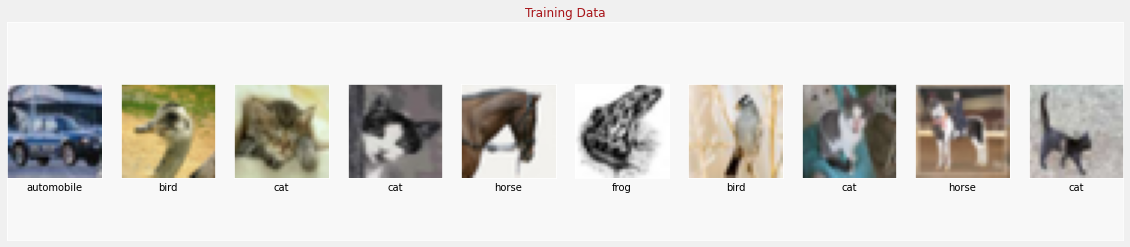

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

def prepare_data(batch_size=batch_size):
  (train_data, validation_data), info = tfds.load("cifar10", split=['train[:60%]', 'train[60%:]'], with_info = True, data_dir='./data/', download=True)
  test_data = tfds.load("cifar10", split = "test", data_dir='./data/', download=False)
  
  train_data = train_data.map(format_image)
  validation_data = validation_data.map(format_image)
  test_data = test_data.map(format_image)

  train = train_data.shuffle(buffer_size=1024).batch(batch_size)
  test_x, test_y = tuple(zip(*test_data))

  test_x = np.array(test_x)
  test_y = np.array(test_y)

  valid_x, valid_y = tuple(zip(*validation_data))

  valid_x = np.array(valid_x)
  valid_y = np.array(valid_y)
  return train, test_x, test_y, valid_x, valid_y

In [ ]:
train, test_x, test_y, valid_x, valid_y = prepare_data()

Shuffling and writing examples to ./data/cifar10/3.0.2.incomplete9HADHE/cifar10-train.tfrecord


Shuffling and writing examples to ./data/cifar10/3.0.2.incomplete9HADHE/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to ./data/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
test_val_accuracy = val_accuracy = sm.accuracy_score
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

### Define custom layers to allow gradient flowing

In [ ]:
class CustomDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, activation=None):
        '''Initializes the instance attributes'''
        super(CustomDense, self).__init__()
        self.units = units
        # define the activation to get from the built-in activation layers in Keras
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = tf.keras.initializers.GlorotUniform()
        self.w = tf.Variable(name="kernel",
            initial_value=w_init(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs, weights, bias):
        '''Defines the computation from inputs to outputs'''

        return self.activation(tf.matmul(inputs, weights) + bias)

In [ ]:
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', **kwargs):
        self.filters = filters
        self.kernel_size = (kernel_size, kernel_size)
        self.padding = padding
        self.batch_norm = tf.keras.layers.BatchNormalization()
        super(CustomConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
       
        shape = (input_shape[:-1] + (self.filters, 0))[:-1]
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                      initializer=tf.keras.initializers.GlorotUniform())

        super(CustomConv2D, self).build(input_shape)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.filters,), dtype='float32'),
            trainable=True)

    def call(self, x, W, bias, strides=1):
        x = tf.nn.conv2d(x, W, strides=strides, padding='SAME')
        x = tf.nn.bias_add(x, bias)
        x = self.batch_norm(x)
        return tf.nn.relu(x)
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

### Define optimizee

In [ ]:
class Cifar10Optimizee(Model):
    def __init__(self):
        super(Cifar10Optimizee, self).__init__()
        # Now we initalize the needed layers - order does not matter.
        # -----------------------------------------------------------
        # CNN LAYERS
        self.conv1 = CustomConv2D(16)
        self.maxp1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = CustomConv2D(32)
        self.maxp2 = tf.keras.layers.MaxPooling2D()
        self.conv3 = CustomConv2D(64)
        self.maxp3 = tf.keras.layers.MaxPooling2D()
        
        # Dense Layers
        self.flatten = tf.keras.layers.Flatten()
        self.dense = CustomDense(20, activation='tanh')
        
        # Output Layer
        self.classifier = CustomDense(10, activation='softmax')
                        
        # keep track of training losses
        self.training_losses, self.validation_losses = [], []
        self.step_training_losses, self.step_validation_losses = [], []

        # keep track of validation losses
        self.validation_losses= []
    
    def call(self, inputs, tensor_trainable_weights):
        # Extract features via CNN Layers
        feature_cnn = self.feature_extractor(inputs, tensor_trainable_weights)
        # Dense layers for classification
        dense_output = self.dense_layers(feature_cnn, tensor_trainable_weights)
        # Classify output
        classification_output = self.classifier_layer(dense_output, tensor_trainable_weights)
        
        return classification_output
    
    '''
    Feature extractor is the CNN that is made up of convolution and pooling layers.
    '''
    def feature_extractor(self, inputs, weights):
        x = self.conv1(inputs, weights[0], weights[1])
        x = self.maxp1(x)

        x = self.conv2(x, weights[2], weights[3])
        x = self.maxp2(x)
        
        x = self.conv3(x, weights[4], weights[5])
        x = self.maxp3(x)

        return x

    '''
    Dense_layers adds a flatten and dense layer.
    This will follow the feature extraction layers
    '''
    def dense_layers(self, inputs, weights):
        x = self.flatten(inputs)
        x = self.dense(x, weights[6], weights[7]) # weights and bias
        return x


    '''
    Classifier defines the classification output.
    This has a set of fully connected layers and a softmax layer.
    '''
    def classifier_layer(self, inputs, weights):
        classification_output = self.classifier(inputs, weights[8], weights[9]) # weights and bias

        return classification_output


### Define functions to train LSTM optimizer and optimizee

In [ ]:
def train_optimizer(train_data, epochs=100, steps_limit=None):
    final_weights = model.tensor_trainable_weights
    max_val = 0
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data, for_optimizer=True, steps_limit=steps_limit)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        if cur_val_acc > max_val:
          max_val = cur_val_acc
          final_weights = model.tensor_trainable_weights
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))
    model.tensor_trainable_weights = final_weights
    print("final val_acc %.4f" % (max_val))

def train_model(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))

def get_validation_data():
    # validation dataset
    validation_predictions = model(valid_x, model.tensor_trainable_weights)
    validation_loss = loss_object(y_true=valid_y, y_pred=validation_predictions)

    # Take the max value after prediction for accuracy metric
    validation_predictions = np.argmax(validation_predictions, axis=1) 
    validation_accuracy = val_accuracy(y_true=valid_y, y_pred=validation_predictions)

    return validation_loss, validation_accuracy

In [ ]:
def train_data_for_one_epoch(train_data, for_optimizer=False, steps_limit=100): 
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    avg_validation_loss = []
    avg_validation_accuracy = []
    avg_loss = []

    for step, (x_batch_train, y_batch_train) in enumerate(train):
      
        if for_optimizer:
          loss = apply_optimizer_gradient(x_batch_train, y_batch_train)
        else:
          loss = apply_gradient(x_batch_train, y_batch_train)
        model.step_training_losses.append(loss)
        avg_loss.append(loss)

        validation_loss, validation_accuracy = get_validation_data()

        # save per step losses
        model.step_validation_losses.append(validation_loss)

        # store validation data
        avg_validation_loss.append(validation_loss)
        avg_validation_accuracy.append(validation_accuracy) 

        pbar.set_description("Training loss for step %s: %.4f val_loss %.4f val_acc %.3f" % (
            int(step), float(loss), float(validation_loss), float(validation_accuracy)
        ))
        pbar.update()

    avg_loss = np.mean(avg_loss)
    avg_validation_loss = np.mean(avg_validation_loss)
    avg_validation_accuracy = np.mean(avg_validation_accuracy)
    return avg_loss, avg_validation_loss, avg_validation_accuracy

def apply_optimizer_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    losses = []
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        tape_master.watch(model.tensor_trainable_weights)

        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch(model.tensor_trainable_weights)

                predictions = model(x_batch_train, model.tensor_trainable_weights)  
                loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
              
                losses.append(loss_value)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                              for i in range(len(model.tensor_trainable_weights))]

        
        losses = tf.reduce_sum(losses)
        
        # calculate the loss against all losses of the optimizee
        lstm_gradients = tape_master.gradient(losses, LSTM_optimizer.trainable_weights)
        lstm_gradients, _ = tf.clip_by_global_norm(lstm_gradients, 0.3)

    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    # calculate average loss
    losses /= LSTM_optimizer.num_unroll
    return losses

def apply_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0
    
    with tf.GradientTape() as tape:
        tape.watch(model.tensor_trainable_weights)

        predictions = model(x_batch_train, model.tensor_trainable_weights)  
        loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

        gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
      
        loss = loss_value
        # Retrieve new results from optimizer
        lstm_optimizer_results = LSTM_optimizer(gradients) 
        # update trainable weights based on the optimer change for that step
        model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                          for i in range(len(model.tensor_trainable_weights))]    
        
    return loss

In [ ]:
def initialize_model():
    # Input Shapes
    model.conv1.build((3, 3, 3, 16))
    model.conv2.build((4, 3, 16, 32))
    model.conv3.build((3, 3, 32, 64)) 
    
    model.dense.build((batch_size, 1024)) 
    model.classifier.build((batch_size, 20))
    model.tensor_trainable_weights = model.trainable_weights

### Define LSTM Optimizers

#### LSTM optimizer with 1 LSTM network
This architecture proved to be not successful for training a network with both CNNs and Dense Layers

In [ ]:
class LSTMOptimizer1(Model):
    def __init__(self, hidden_size, num_layers, num_unroll, preprocessing_value=10, **kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.lstm_cell_list = []
        self.cnn_batches = [432, 16, 6144, 32, 18432, 64]
        self.dense_batches = [20480, 20, 200, 10]
        self.batches = self.cnn_batches + self.dense_batches
        self.preprocessing_value = preprocessing_value
        self.num_cnn_layers = len(self.cnn_batches)
        self.num_dense_layers = len(self.dense_batches)
        self.batch_norm_cnn = tf.keras.layers.BatchNormalization()
        self.batch_norm_dense = tf.keras.layers.BatchNormalization()

        # one optimizer for CNNS and one for Dense layers
        self.lstm_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size) for _ in range(num_layers)])
            
        self.refresh_state()  # initialize state 
        self.num_unroll = num_unroll
        
    def refresh_state(self): 
        # refresh lstms state list
        self.state_list = [self.lstm_cells.get_initial_state(batch_size = self.batches[i], dtype = 'float') for i in range(len(self.batches))]

    def preprocess_inputs(self, flattened_grad):
      # Preprocessing
      preprocessed_inputs = np.zeros(shape=(flattened_grad.shape[0], 2))

      condition = tf.greater_equal(flattened_grad, np.abs(flattened_grad) >= np.exp(-self.preprocessing_value))
      case_true1 = np.log(np.abs(flattened_grad) + 1e-8 ) / self.preprocessing_value # 1e-8 to help calculating gradient and stop the vanishing gradient issue
      case_false1 = -1
      preprocessed_inputs[:, 0] = tf.where(condition, case_true1, case_false1)

      case_true2 = np.sign(flattened_grad)
      case_false2 = np.exp(self.preprocessing_value) * flattened_grad
      preprocessed_inputs[:, 1] = tf.where(condition, case_true2, case_false2)
      return preprocessed_inputs
  
    def dense_layers_call(self, dense_layers_gradients):
        g_new_list = []
        for i in range(self.num_dense_layers):
            gradient = dense_layers_gradients[i] # The gradient of the i-th parameter
            state = self.state_list[self.num_cnn_layers + i]
            try:
                gradient.shape[1] # check if the tensor is 2D as this is what the cell() accepts
            except:
                gradient = tf.reshape(gradient, [gradient.shape[0], 1]) # make tensor 2D which is compatible with cell call function 
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell
            preprocessed_inputs = self.preprocess_inputs(flattened_grad)
            cell_output, state = self.lstm_cells(preprocessed_inputs, state)


            self.state_list[self.num_cnn_layers + i] = state # update the state
            cell_output = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 
            cell_output = tf.reshape(cell_output, [gradient.shape[0], gradient.shape[1]]) # reshape the update back to the dimension of the gradients
            cell_output = cell_output * 0.01
            g_new_list.append(cell_output)
        
        g_new_list[1] = tf.squeeze(g_new_list[1]) # biases
        g_new_list[3] = tf.squeeze(g_new_list[3]) # biases

        return g_new_list
    
    
    def cnn_layers_call(self, cnn_layers_gradients):
        g_new_list = []
        for i in range(self.num_cnn_layers):
            gradient = cnn_layers_gradients[i] # The gradient of the i-th parameter
            state = self.state_list[i]    
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell
            preprocessed_inputs = self.preprocess_inputs(flattened_grad)
            cell_output, state = self.lstm_cells(preprocessed_inputs, state) 
            cell_output = self.batch_norm_cnn(cell_output)

            self.state_list[i] = state # update the state
            cell_output = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 
            if i % 2 == 0:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], gradient.shape[1], gradient.shape[2], gradient.shape[3]]) # reshape the update back to the dimension of the gradients
            else:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], ]) # reshape bias
            cell_output = cell_output * 0.01
            g_new_list.append(cell_output)
        
        return g_new_list
    
    def call(self, gradients):
        cnn_gradients_update = []
        cnn_gradients_update = self.cnn_layers_call(gradients[:self.num_cnn_layers])
        dense_gradients_update = self.dense_layers_call(gradients[self.num_cnn_layers:])
        gradient_update_list = cnn_gradients_update + dense_gradients_update
        return gradient_update_list

#### LSTM Optimizer with 2 distinct LSTM Layers


1.   1 LSTM layer for Dense layers
2.   1 LSTM layer for CNNs



In [ ]:
class LSTMOptimizer(Model):
    def __init__(self, hidden_size, num_layers, num_unroll, preprocessing_value=10, **kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.lstm_cell_list = []
        self.cnn_batches = [432, 16, 6144, 32, 18432, 64]
        self.dense_batches = [20480, 20, 200, 10]
        self.batches = self.cnn_batches + self.dense_batches
        self.batch_norm_cnn = tf.keras.layers.BatchNormalization()
        self.batch_norm_dense = tf.keras.layers.BatchNormalization()
        self.learning_rate = 0.001

        self.preprocessing_value = preprocessing_value
        self.num_cnn_layers = len(self.cnn_batches)
        self.num_dense_layers = len(self.dense_batches)
        for i in range(2):
            self.lstm_cell_list.append(tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size) for _ in range(num_layers)]))
            
        self.num_unroll = num_unroll
        
    def refresh_state(self): 
        # CNN state list
        self.cnn_state_list = [self.lstm_cell_list[0].get_initial_state(batch_size = self.cnn_batches[i], dtype = 'float') for i in range(self.num_cnn_layers)]
        # Dense state list
        self.dense_state_list = [self.lstm_cell_list[1].get_initial_state(batch_size = self.dense_batches[i], dtype = 'float') for i in range(self.num_dense_layers)]

    def preprocess_inputs(self, flattened_grad):
      # Preprocessing
      preprocessed_inputs = np.zeros(shape=(flattened_grad.shape[0], 2))

      condition = tf.greater_equal(flattened_grad, np.abs(flattened_grad) >= np.exp(-self.preprocessing_value))
      case_true1 = np.log(np.abs(flattened_grad) + 1e-8 ) / self.preprocessing_value # 1e-8 to help calculating gradient and stop the vanishing gradient issue
      case_false1 = -1
      preprocessed_inputs[:, 0] = tf.where(condition, case_true1, case_false1)

      case_true2 = np.sign(flattened_grad)
      case_false2 = np.exp(self.preprocessing_value) * flattened_grad
      preprocessed_inputs[:, 1] = tf.where(condition, case_true2, case_false2)
      return preprocessed_inputs

    def dense_layers_call(self, dense_layers_gradients):
        g_new_list = []
        lstm_dense_cells = self.lstm_cell_list[1] # dense_layers_optimizer
        for i in range(self.num_dense_layers):
            gradient = dense_layers_gradients[i] # The gradient of the i-th parameter
            state = self.dense_state_list[i]
            try:
                gradient.shape[1] # check if the tensor is 2D as this is what the cell() accepts
            except:
                gradient = tf.reshape(gradient, [gradient.shape[0], 1]) # make tensor 2D which is compatible with cell call function 
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell

            preprocessed_inputs = self.preprocess_inputs(flattened_grad)
            preprocessed_inputs = self.batch_norm_dense(preprocessed_inputs)

            cell_output, state = lstm_dense_cells(preprocessed_inputs, state) 
            self.dense_state_list[i] = state # update the state
            cell_output = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 
            cell_output = tf.reshape(cell_output, [gradient.shape[0], gradient.shape[1]]) # reshape the update back to the dimension of the gradient
            cell_output = cell_output * self.learning_rate
            g_new_list.append(cell_output)
        
        g_new_list[1] = tf.squeeze(g_new_list[1]) # biases
        g_new_list[3] = tf.squeeze(g_new_list[3]) # biases

        return g_new_list
    
    
    def cnn_layers_call(self, cnn_layers_gradients):
        g_new_list = []
        lstm_cnn_cells = self.lstm_cell_list[0]
        for i in range(self.num_cnn_layers):
            gradient = cnn_layers_gradients[i] # The gradient of the i-th parameter
            state = self.cnn_state_list[i]    
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell
            preprocessed_inputs = self.preprocess_inputs(flattened_grad)
            preprocessed_inputs = self.batch_norm_cnn(preprocessed_inputs)
          
            cell_output, state = lstm_cnn_cells(preprocessed_inputs, state) 
            self.cnn_state_list[i] = state # update the state
            cell_output = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 
          
            if i % 2 == 0:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], gradient.shape[1], gradient.shape[2], gradient.shape[3]]) # reshape the update back to the dimension of the gradients
            else:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], ]) # reshape bias
            cell_output = cell_output * self.learning_rate
            g_new_list.append(cell_output)
        
        return g_new_list

    
    def call(self, gradients):
        cnn_gradients_update = []
        cnn_gradients_update = self.cnn_layers_call(gradients[:self.num_cnn_layers])
        dense_gradients_update = self.dense_layers_call(gradients[self.num_cnn_layers:])
        gradient_update_list = cnn_gradients_update + dense_gradients_update
        return gradient_update_list

### Train of LSTM optimizer and optimizee

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=20, num_layers=3, num_unroll=20)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_optimizer(train, epochs=2)

Training loss for step 149: 1.8916 val_loss 1.9197 val_acc 0.289: 100%|██████████| 150/150 


 Epoch: 0 => loss: 2.0096 ,avg_val_loss: 2.0466 avg_val_acc: 0.2446, current_val_Acc 0.2894 



Training loss for step 149: 1.9045 val_loss 1.9128 val_acc 0.272: 100%|██████████| 150/150 


 Epoch: 1 => loss: 1.9305 ,avg_val_loss: 1.9722 avg_val_acc: 0.2538, current_val_Acc 0.2718 



In [ ]:
LSTM_optimizer.learning_rate = 0.01

In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_model(train, epochs=2)

Training loss for step 149: 2.2261 val_loss 2.2239 val_acc 0.189: 100%|██████████| 150/150 


 Epoch: 0 => loss: 2.2684 ,avg_val_loss: 2.2643 avg_val_acc: 0.1572, current_val_Acc 0.1885 



Training loss for step 149: 2.2183 val_loss 2.2028 val_acc 0.211: 100%|██████████| 150/150 


 Epoch: 1 => loss: 2.2174 ,avg_val_loss: 2.2102 avg_val_acc: 0.2070, current_val_Acc 0.2109 



## Define Cifar Model for hand crafted optimizers

In [ ]:
class NormalCifarModel(tf.keras.Model):

    def __init__(self):
        super(NormalCifarModel, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', name='conv_1')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.cnn2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu', name='conv_2')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.cnn3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu', name='conv_3')
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(20, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.pool1(x)
        x = self.cnn2(x)
        x = self.pool2(x)
        x = self.cnn3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [ ]:
class NormalCifarModelSimple(tf.keras.Model):

    def __init__(self):
        super(NormalCifarModelSimple, self).__init__()

        self.cnn1 = tf.keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', name='conv_1')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.cnn2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu', name='conv_2')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.cnn3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu', name='conv_3')
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(20, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.cnn1(inputs)
        x = self.pool1(x)
        x = self.cnn2(x)
        x = self.pool2(x)
        x = self.cnn3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [ ]:
def train_data_for_one_epoch_hand_crafted(model, optimizer, steps=None, steps_limit=None):
  # store per step
  step_train_losses, step_valid_losses = [], []

  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      if steps_limit:
        if steps == steps_limit:
        # if we reach defined number of steps break
          break
        else:
          steps += 1

      logits, loss_value = apply_gradient_hand_crafted_models(model, optimizer, x_batch_train, y_batch_train)
      
      step_train_losses.append(loss_value)
      valid_losses, validation_accuracy = perform_validation(model)
      step_valid_losses.append(valid_losses)

      pbar.set_description("Training loss for step %s: %.4f, validation loss: %.4f, validation accuracy: %.4f" % (int(step), float(loss_value), float(valid_losses), float(validation_accuracy)))
      pbar.update()

  return step_train_losses, step_valid_losses, steps

In [ ]:
def perform_validation(model):
  val_logits = model(valid_x)
  val_loss = loss_object(y_true=valid_y, y_pred=val_logits)
  
  val_logits = np.argmax(val_logits, axis=1) 
  current_val_accuracy = val_accuracy(np.array(valid_y), val_logits)
  return val_loss, current_val_accuracy

In [ ]:
def apply_gradient_hand_crafted_models(model, optimizer, train_X, train_y):
    with tf.GradientTape() as tape:
      predictions = model(train_X)
      current_loss = loss_object(train_y, predictions)

    gradients = tape.gradient(current_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return predictions, current_loss

In [ ]:
def train_hand_crafted_models(model, optimizer, epochs=1, steps_limit=None):
  train_losses, valid_losses = [], []
  steps_train_losses, steps_valid_losses = [], []
  validation_accuracy_data = []
  steps = None
  for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    current_step_train_losses, current_step_valid_losses, steps = train_data_for_one_epoch_hand_crafted(model, optimizer, steps, steps_limit)
    train_losses.append(np.mean(current_step_train_losses))
    valid_losses.append(np.mean(current_step_valid_losses)) 
    steps_train_losses += current_step_train_losses
    steps_valid_losses += current_step_valid_losses

    _ , validation_accuracy = perform_validation(model)
    validation_accuracy_data.append(validation_accuracy)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(current_step_train_losses)), float(np.mean(current_step_valid_losses)), float(validation_accuracy)))
    
  history_data = {
      "loss": np.array(train_losses),
      "valid_loss": np.array(valid_losses),
      "steps_train_losses": np.array(steps_train_losses),
      "steps_valid_losses": np.array(steps_valid_losses),
      "val_accuracy": np.array(validation_accuracy_data)
  }
  return history_data

## Define plot methods and accuracy methods

In [ ]:
def plot_steps_train_results():
  plt.plot(np.array(model.step_training_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_train_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_train_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_train_losses'], label='SGD optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Training Loss') 
  plt.title('Hand crafted and learned Optimizer losses CIFAR-10')
  # show a legend on the plot
  plt.legend(loc=1)

def plot_steps_valid_results():
  plt.plot(np.array(model.step_validation_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_valid_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_valid_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_valid_losses'], label='SGD optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Validation Loss') 
  plt.title('Hand crafted and learned Optimizer losses CIFAR-10')
  # show a legend on the plot
  plt.legend(loc=1)


In [ ]:
def print_accuracy_report(optimizer_name, test_y, preds):
    print(f"***** {optimizer_name} Accuracy metrics******")
    print(sm.classification_report(test_y, preds, target_names=class_names))
    print()

def print_accuracy_reports():
  print_accuracy_report("LSTM_optimizer", test_y, np.argmax(lstm_optimizer_preds, axis=1))
  print_accuracy_report("RMSProp", test_y, np.argmax(rms_preds, axis=1))
  print_accuracy_report("ADAM", test_y, np.argmax(adam_preds, axis=1))
  print_accuracy_report("SGD", test_y, np.argmax(sgd_preds, axis=1))

## Train hand crafted optimizers

In [ ]:
adam_model = NormalCifarModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=2)
rmsprop_model = NormalCifarModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=2)
sgd_model = NormalCifarModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=2)

Start of epoch 0


Training loss for step 149: 1.9179, validation loss: 1.8434, validation accuracy: 0.3235: 100%|██████████| 150/150 


 Epoch 0: Train loss: 2.0763  Validation Loss: 2.0672, Validation Accuracy 0.3235
Start of epoch 1


Training loss for step 149: 1.6600, validation loss: 1.6398, validation accuracy: 0.4056: 100%|██████████| 150/150 


 Epoch 1: Train loss: 1.7377  Validation Loss: 1.7333, Validation Accuracy 0.4056
Start of epoch 0


Training loss for step 149: 1.9219, validation loss: 1.9166, validation accuracy: 0.3127: 100%|██████████| 150/150 


 Epoch 0: Train loss: 2.0633  Validation Loss: 2.0595, Validation Accuracy 0.3127
Start of epoch 1


Training loss for step 149: 1.6220, validation loss: 1.7441, validation accuracy: 0.3704: 100%|██████████| 150/150 


 Epoch 1: Train loss: 1.8066  Validation Loss: 1.8037, Validation Accuracy 0.3704
Start of epoch 0


Training loss for step 149: 2.2894, validation loss: 2.2882, validation accuracy: 0.1184: 100%|██████████| 150/150 


 Epoch 0: Train loss: 2.2966  Validation Loss: 2.2969, Validation Accuracy 0.1184
Start of epoch 1


Training loss for step 149: 2.2364, validation loss: 2.2568, validation accuracy: 0.1349: 100%|██████████| 150/150 


 Epoch 1: Train loss: 2.2750  Validation Loss: 2.2749, Validation Accuracy 0.1349


## Plot graphs

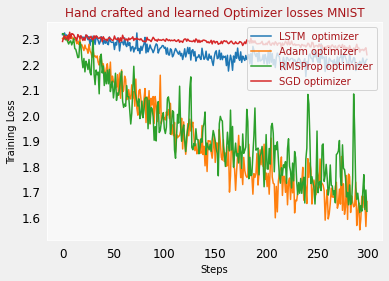

In [ ]:
plot_steps_train_results()

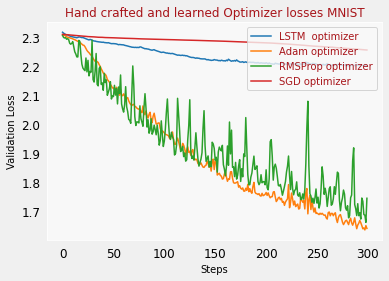

In [ ]:
plot_steps_valid_results()

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.46      0.03      0.05      1000
        bird       0.16      0.23      0.19      1000
         cat       0.15      0.45      0.23      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.14      0.25      0.18      1000
       horse       0.21      0.00      0.01      1000
        ship       0.33      0.54      0.41      1000
       truck       0.25      0.55      0.34      1000

    accuracy                           0.20     10000
   macro avg       0.17      0.20      0.14     10000
weighted avg       0.17      0.20      0.14     10000


***** RMSProp Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.57      0.39      0.46      1000
  automobile       0.60      0.43      0.50      1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test learning rate

In [ ]:
# LSTM_optimizer = LSTMOptimizer(hidden_size=20, num_layers=3, num_unroll=20)
LSTM_optimizer = LSTMOptimizer(hidden_size=20, num_layers=3, num_unroll=20)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0009)

In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_optimizer(train, epochs=2)

Training loss for step 149: 1.7979 val_loss 1.8392 val_acc 0.323: 100%|██████████| 150/150 


 Epoch: 0 => loss: 1.9277 ,avg_val_loss: 1.9749 avg_val_acc: 0.2596, current_val_Acc 0.3227 



Training loss for step 149: 1.6320 val_loss 1.6895 val_acc 0.384: 100%|██████████| 150/150 


 Epoch: 1 => loss: 1.7492 ,avg_val_loss: 1.8137 avg_val_acc: 0.3321, current_val_Acc 0.3842 

final val_acc 0.3842


In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
LSTM_optimizer.learning_rate = 0.01

In [ ]:
train_model(train, epochs=2)

In [ ]:
adam_model = NormalCifarModelSimple()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=2)
rmsprop_model = NormalCifarModelSimple()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=2)
sgd_model = NormalCifarModelSimple()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=2)
adagrad_model = NormalCifarModelSimple()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=2)

Start of epoch 0


Training loss for step 99: 1.9439, validation loss: 1.9217, validation accuracy: 0.3129:  99%|█████████▉| 99/100 


 Epoch 0: Train loss: 2.0919  Validation Loss: 2.0841, Validation Accuracy 0.3129
Start of epoch 0


Training loss for step 99: 1.8812, validation loss: 1.8941, validation accuracy: 0.3109:  99%|█████████▉| 99/100 


 Epoch 0: Train loss: 2.0434  Validation Loss: 2.0429, Validation Accuracy 0.3109
Start of epoch 0


Training loss for step 99: 2.2703, validation loss: 2.2485, validation accuracy: 0.1523:  99%|█████████▉| 99/100 


 Epoch 0: Train loss: 2.2779  Validation Loss: 2.2765, Validation Accuracy 0.1523
Start of epoch 0


Training loss for step 99: 2.2681, validation loss: 2.2779, validation accuracy: 0.1622:  99%|█████████▉| 99/100 


 Epoch 0: Train loss: 2.2955  Validation Loss: 2.2955, Validation Accuracy 0.1622


### Plot results

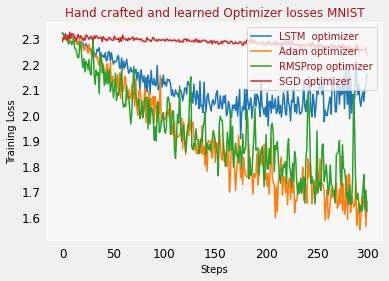

In [ ]:
plot_steps_train_results()

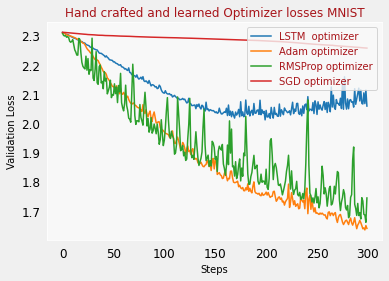

In [ ]:
plot_steps_valid_results()

## Train for longer test

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=15, num_layers=3, batch_size=batch_size, num_unroll=20)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_optimizer(train, epochs=10)

Training loss for step 99: 1.4679 val_loss 1.4669 val_acc 0.480: 100%|██████████| 100/100 


 Epoch: 0 => loss: 1.4534 ,avg_val_loss: 1.4655 avg_val_acc: 0.4793, current_val_Acc 0.4798 



Training loss for step 99: 1.4226 val_loss 1.4570 val_acc 0.483: 100%|██████████| 100/100 


 Epoch: 1 => loss: 1.4504 ,avg_val_loss: 1.4626 avg_val_acc: 0.4804, current_val_Acc 0.4827 



Training loss for step 99: 1.4651 val_loss 1.4595 val_acc 0.481: 100%|██████████| 100/100 


 Epoch: 2 => loss: 1.4465 ,avg_val_loss: 1.4593 avg_val_acc: 0.4818, current_val_Acc 0.4806 



Training loss for step 99: 1.4156 val_loss 1.4662 val_acc 0.479: 100%|██████████| 100/100 


 Epoch: 3 => loss: 1.4440 ,avg_val_loss: 1.4569 avg_val_acc: 0.4830, current_val_Acc 0.4786 



Training loss for step 99: 1.4637 val_loss 1.4511 val_acc 0.489: 100%|██████████| 100/100 


 Epoch: 4 => loss: 1.4425 ,avg_val_loss: 1.4551 avg_val_acc: 0.4844, current_val_Acc 0.4886 



Training loss for step 99: 1.4592 val_loss 1.4524 val_acc 0.485: 100%|██████████| 100/100 


 Epoch: 5 => loss: 1.4381 ,avg_val_loss: 1.4517 avg_val_acc: 0.4860, current_val_Acc 0.4854 



Training loss for step 99: 1.4065 val_loss 1.4449 val_acc 0.488: 100%|██████████| 100/100 


 Epoch: 6 => loss: 1.4357 ,avg_val_loss: 1.4496 avg_val_acc: 0.4867, current_val_Acc 0.4877 



Training loss for step 99: 1.3634 val_loss 1.4499 val_acc 0.492: 100%|██████████| 100/100 


 Epoch: 7 => loss: 1.4355 ,avg_val_loss: 1.4492 avg_val_acc: 0.4872, current_val_Acc 0.4918 



Training loss for step 99: 1.4649 val_loss 1.4556 val_acc 0.482: 100%|██████████| 100/100 


 Epoch: 8 => loss: 1.4339 ,avg_val_loss: 1.4471 avg_val_acc: 0.4873, current_val_Acc 0.4820 



Training loss for step 99: 1.3540 val_loss 1.4398 val_acc 0.492: 100%|██████████| 100/100 


 Epoch: 9 => loss: 1.4318 ,avg_val_loss: 1.4455 avg_val_acc: 0.4884, current_val_Acc 0.4919 



In [ ]:
model = Cifar10Optimizee()
initialize_model()

In [ ]:
train_model(train, epochs=3)

Training loss for step 99: 2.0433 val_loss 2.0479 val_acc 0.298: 100%|██████████| 100/100 


 Epoch: 0 => loss: 2.1722 ,avg_val_loss: 2.1676 avg_val_acc: 0.2423, current_val_Acc 0.2985 



Training loss for step 99: 1.8651 val_loss 1.8841 val_acc 0.362: 100%|██████████| 100/100 


 Epoch: 1 => loss: 1.9627 ,avg_val_loss: 1.9577 avg_val_acc: 0.3305, current_val_Acc 0.3623 



Training loss for step 99: 1.7830 val_loss 1.7931 val_acc 0.390: 100%|██████████| 100/100 


 Epoch: 2 => loss: 1.8390 ,avg_val_loss: 1.8348 avg_val_acc: 0.3732, current_val_Acc 0.3900 



In [ ]:
adam_model = NormalCifarModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=3)
rmsprop_model = NormalCifarModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=3)
sgd_model = NormalCifarModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=3)
adagrad_model = NormalCifarModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=3)

Start of epoch 0


Training loss for step 99: 1.9257, validation loss: 1.8962, validation accuracy: 0.2863: 100%|██████████| 100/100 


 Epoch 0: Train loss: 2.0850  Validation Loss: 2.0832, Validation Accuracy 0.2863
Start of epoch 1


Training loss for step 99: 1.7527, validation loss: 1.6612, validation accuracy: 0.3957:  99%|█████████▉| 99/100 


 Epoch 1: Train loss: 1.7603  Validation Loss: 1.7579, Validation Accuracy 0.3957
Start of epoch 2


Training loss for step 99: 1.5328, validation loss: 1.5314, validation accuracy: 0.4532: 100%|██████████| 100/100 


 Epoch 2: Train loss: 1.5840  Validation Loss: 1.5819, Validation Accuracy 0.4532
Start of epoch 0


Training loss for step 99: 1.9389, validation loss: 1.9652, validation accuracy: 0.2851:  99%|█████████▉| 99/100 


 Epoch 0: Train loss: 2.1067  Validation Loss: 2.1036, Validation Accuracy 0.2851
Start of epoch 1


Training loss for step 99: 1.7985, validation loss: 1.7713, validation accuracy: 0.3599:  99%|█████████▉| 99/100 


 Epoch 1: Train loss: 1.8809  Validation Loss: 1.8773, Validation Accuracy 0.3599
Start of epoch 2


Training loss for step 99: 1.7650, validation loss: 1.7261, validation accuracy: 0.3730:  99%|█████████▉| 99/100 


 Epoch 2: Train loss: 1.7544  Validation Loss: 1.7568, Validation Accuracy 0.3730
Start of epoch 0


Training loss for step 99: 2.2962, validation loss: 2.2961, validation accuracy: 0.1401:  99%|█████████▉| 99/100 


 Epoch 0: Train loss: 2.2985  Validation Loss: 2.2990, Validation Accuracy 0.1401
Start of epoch 1


Training loss for step 99: 2.2892, validation loss: 2.2911, validation accuracy: 0.1741:  99%|█████████▉| 99/100 


 Epoch 1: Train loss: 2.2931  Validation Loss: 2.2936, Validation Accuracy 0.1741
Start of epoch 2


Training loss for step 99: 2.2843, validation loss: 2.2845, validation accuracy: 0.1878:  99%|█████████▉| 99/100 


 Epoch 2: Train loss: 2.2876  Validation Loss: 2.2879, Validation Accuracy 0.1878
Start of epoch 0


Training loss for step 99: 2.3064, validation loss: 2.3033, validation accuracy: 0.1004:  99%|█████████▉| 99/100 


 Epoch 0: Train loss: 2.3048  Validation Loss: 2.3038, Validation Accuracy 0.1004
Start of epoch 1


Training loss for step 99: 2.3037, validation loss: 2.3024, validation accuracy: 0.1003:  99%|█████████▉| 99/100 


 Epoch 1: Train loss: 2.3036  Validation Loss: 2.3028, Validation Accuracy 0.1003
Start of epoch 2


Training loss for step 99: 2.3014, validation loss: 2.3017, validation accuracy: 0.0993:  99%|█████████▉| 99/100 


 Epoch 2: Train loss: 2.3026  Validation Loss: 2.3020, Validation Accuracy 0.0993


### Plot results

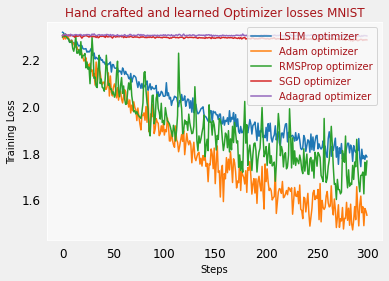

In [ ]:
plot_steps_train_results()

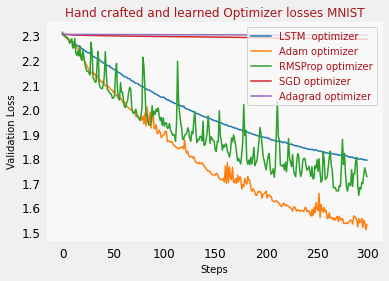

In [ ]:
plot_steps_valid_results()

### Accuracy

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.44      0.49      0.46      1000
  automobile       0.42      0.46      0.44      1000
        bird       0.34      0.13      0.19      1000
         cat       0.30      0.16      0.21      1000
        deer       0.35      0.40      0.37      1000
         dog       0.38      0.33      0.36      1000
        frog       0.41      0.54      0.47      1000
       horse       0.43      0.33      0.37      1000
        ship       0.40      0.59      0.48      1000
       truck       0.38      0.49      0.42      1000

    accuracy                           0.39     10000
   macro avg       0.38      0.39      0.38     10000
weighted avg       0.38      0.39      0.38     10000


***** Adagrad Accuracy metrics******
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
